In [2]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_colwidth', 300)


In [4]:
meta = pd.read_csv("./MovieSummaries/movie.metadata.tsv", sep = '\t', header = None)
meta.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [5]:
meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]

In [7]:
plots = []

with open("./MovieSummaries/plot_summaries.txt", 'r') as f:
       reader = csv.reader(f, dialect='excel-tab') 
       for row in tqdm(reader):
            plots.append(row)

42303it [00:01, 24932.41it/s]


In [8]:
movie_id = []
plot = []

# extract movie Ids and plot summaries
for i in tqdm(plots):
  movie_id.append(i[0])
  plot.append(i[1])

# create dataframe
movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})

100%|██████████| 42303/42303 [00:00<00:00, 824757.09it/s]


In [9]:
movies.head()

,movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole..."
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e..."
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo..."
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r..."


In [10]:
# change datatype of 'movie_id'
meta['movie_id'] = meta['movie_id'].astype(str)

# merge meta with movies
movies = pd.merge(movies, meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')

movies.head()

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}"


In [11]:
movies['genre'][0]

'{"/m/07s9rl0": "Drama", "/m/03q4nz": "World cinema"}'

In [12]:
type(json.loads(movies['genre'][0]))

dict

In [13]:
json.loads(movies['genre'][0]).values()

dict_values(['Drama', 'World cinema'])

In [14]:
dict_values(['Drama', 'World cinema'])


NameError: name 'dict_values' is not defined

In [15]:
# an empty list
genres = [] 

# extract genres
for i in movies['genre']: 
  genres.append(list(json.loads(i).values())) 

# add to 'movies' dataframe  
movies['genre_new'] = genres

In [16]:
movies_new = movies[~(movies['genre_new'].str.len() == 0)]

In [17]:
movies_new.shape, movies.shape

((41793, 5), (42204, 5))

In [18]:
movies.head()

,movie_id,plot,movie_name,genre,genre_new
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}","[Drama, World cinema]"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}","[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}","[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}","[Screwball comedy, Comedy]"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}","[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


In [29]:
all_genre = sum(genres,[])
len(set(all_genre))

363

In [33]:

all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

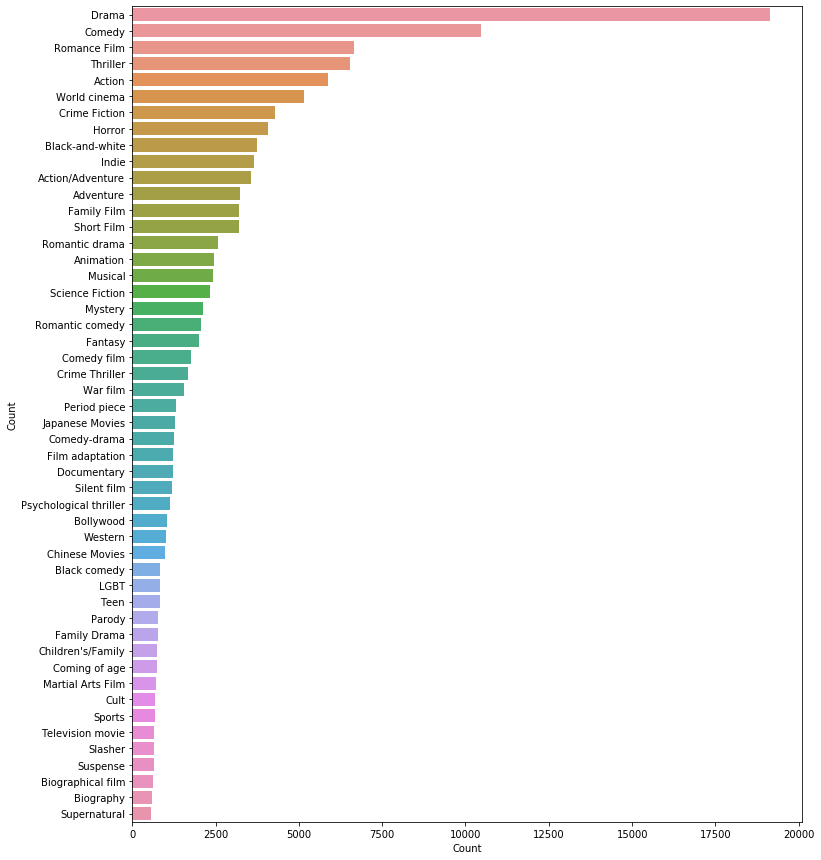

In [34]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [35]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [36]:
movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))

/home/ishank/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
pd.options.mode.chained_assignment = None  # default='warn'


In [38]:
movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))

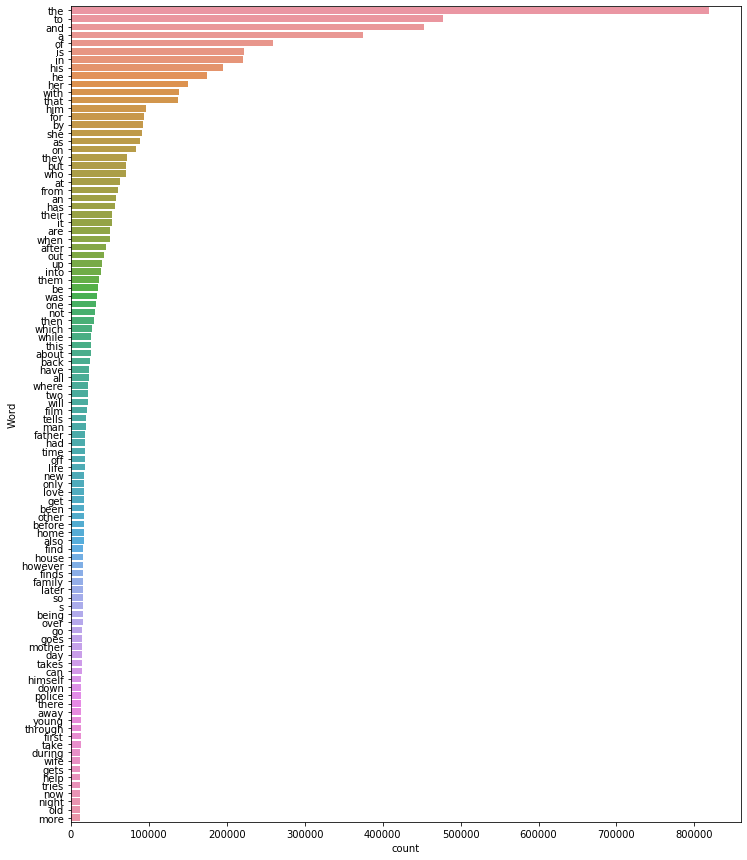

In [39]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(movies_new['clean_plot'], 100)

In [40]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/ishank/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))

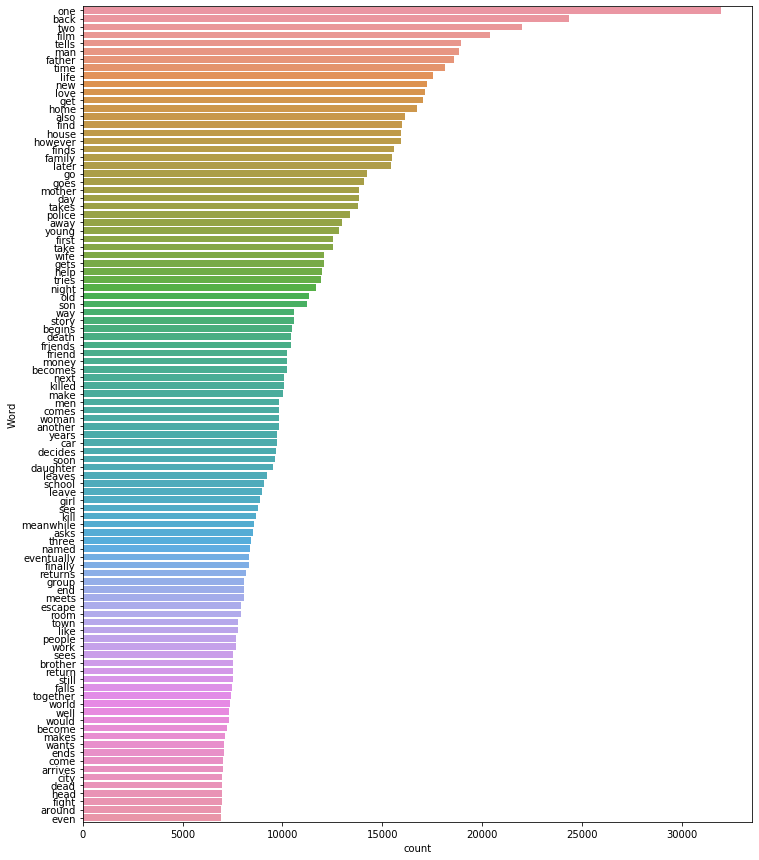

In [42]:
freq_words(movies_new['clean_plot'], 100)

In [71]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(movies_new['genre_new'])
print(y)

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [44]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)


In [45]:
xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_plot'], y, test_size=0.2, random_state=9)


In [46]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [47]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [48]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [183]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

/home/ishank/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ishank/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 48 is present in all training examples.
  str(classes[c]))
/home/ishank/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 182 is present in all training examples.
  str(classes[c]))
/home/ishank/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 214 is present in all training examples.
  str(classes[c]))
/home/ishank/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 245 is present in all training examples.
  str(classes[c]))


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [185]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [186]:
y_pred[3]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [187]:
multilabel_binarizer.inverse_transform(y_pred)[3]


('Action', 'Drama')

In [188]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.31539641943734015

In [189]:
y_pred_prob = clf.predict_proba(xval_tfidf)

In [190]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [191]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.4378456703198025

In [192]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [201]:
for i in range(5): 
  k = xval.sample(1).index[0]
  print("Movie: ", movies_new['movie_name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",movies_new['genre_new'][k], "\n")

Movie:  Zindagani 
Predicted genre:  [('Action', 'Drama')]
Actual genre:  ['Drama', 'World cinema'] 

Movie:  Volunteers 
Predicted genre:  [('Drama',)]
Actual genre:  ['Adventure Comedy', 'Buddy film', 'Comedy'] 

Movie:  The Far Paradise 
Predicted genre:  [()]
Actual genre:  ['Silent film', 'Drama', 'Romance Film'] 

Movie:  Best Laid Plans 
Predicted genre:  [()]
Actual genre:  ['Drama'] 

Movie:  Minnesota Cuke and The Search For Noah's Umbrella 
Predicted genre:  [()]
Actual genre:  ['Short Film', 'Musical', "Children's", 'Animation'] 



In [194]:
df1 = pd.read_csv('./IMDB-Movie-Data.csv')
df1.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced to work together to stop a fanatical warrior from taking control of the universe.,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe Saldana",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a team finds a structure on a distant moon, but they soon realize they are not alone.",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fassbender, Charlize Theron",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diagnosed 23 distinct personalities. They must try to escape before the apparent emergence of a frightful new 24th.,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richardson, Jessica Sula",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling theater impresario's attempt to save his theater with a singing competition becomes grander than he anticipates even as its finalists' find that their lives will never be the same.",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth MacFarlane, Scarlett Johansson",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of the most dangerous incarcerated super-villains to form a defensive task force. Their first mission: save the world from the apocalypse.,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola Davis",2016,123,6.2,393727,325.02,40.0


In [202]:
for index, row in df1.iterrows():
    print(row["Title"]+'------------->'+row["Genre"])
    print(row['Description'])
    print('Predicted-->',infer_tags(row['Description']))
    print()

Guardians of the Galaxy------------->Action,Adventure,Sci-Fi
A group of intergalactic criminals are forced to work together to stop a fanatical warrior from taking control of the universe.
Predicted--> [()]

Prometheus------------->Adventure,Mystery,Sci-Fi
Following clues to the origin of mankind, a team finds a structure on a distant moon, but they soon realize they are not alone.
Predicted--> [('Drama',)]

Split------------->Horror,Thriller
Three girls are kidnapped by a man with a diagnosed 23 distinct personalities. They must try to escape before the apparent emergence of a frightful new 24th.
Predicted--> [()]

Sing------------->Animation,Comedy,Family
In a city of humanoid animals, a hustling theater impresario's attempt to save his theater with a singing competition becomes grander than he anticipates even as its finalists' find that their lives will never be the same.
Predicted--> [()]

Suicide Squad------------->Action,Adventure,Fantasy
A secret government agency recruits some

Predicted--> [('Drama',)]

The Magnificent Seven------------->Action,Adventure,Western
Seven gunmen in the old west gradually come together to help a poor village against savage thieves.
Predicted--> [()]

5- 25- 77------------->Comedy,Drama
Alienated, hopeful-filmmaker Pat Johnson's epic story growing up in rural Illinois, falling in love, and becoming the first fan of the movie that changed everything.
Predicted--> [('Drama',)]

Sausage Party------------->Animation,Adventure,Comedy
A sausage strives to discover the truth about his existence.
Predicted--> [()]

Moonlight------------->Drama
A chronicle of the childhood, adolescence and burgeoning adulthood of a young, African-American, gay man growing up in a rough neighborhood of Miami.
Predicted--> [('Drama',)]

Don't Fuck in the Woods------------->Horror
A group of friends are going on a camping trip to celebrate graduating college. But once they enter the woods, the proverbial shit starts to hit the fan.
Predicted--> [()]

The Foun

Predicted--> [()]

Inglourious Basterds------------->Adventure,Drama,War
In Nazi-occupied France during World War II, a plan to assassinate Nazi leaders by a group of Jewish U.S. soldiers coincides with a theatre owner's vengeful plans for the same.
Predicted--> [('Drama', 'War film')]

Pirates of the Caribbean: Dead Man's Chest------------->Action,Adventure,Fantasy
Jack Sparrow races to recover the heart of Davy Jones to avoid enslaving his soul to Jones' service, as other friends and foes seek the heart for their own agenda as well.
Predicted--> [()]

Ghostbusters------------->Action,Comedy,Fantasy
Following a ghost invasion of Manhattan, paranormal enthusiasts Erin Gilbert and Abby Yates, nuclear engineer Jillian Holtzmann, and subway worker Patty Tolan band together to stop the otherworldly threat.
Predicted--> [()]

Inception------------->Action,Adventure,Sci-Fi
A thief, who steals corporate secrets through use of dream-sharing technology, is given the inverse task of planting an 

Predicted--> [()]

10 Cloverfield Lane------------->Drama,Horror,Mystery
After getting in a car accident, a woman is held in a shelter with two men, who claim the outside world is affected by a widespread chemical attack.
Predicted--> [('Drama',)]

Finding Dory------------->Animation,Adventure,Comedy
The friendly but forgetful blue tang fish, Dory, begins a search for her long-lost parents, and everyone learns a few things about the real meaning of family along the way.
Predicted--> [('Comedy',)]

Miss Peregrine's Home for Peculiar Children------------->Adventure,Drama,Family
When Jacob discovers clues to a mystery that stretches across time, he finds Miss Peregrine's Home for Peculiar Children. But the danger deepens after he gets to know the residents and learns about their special powers.
Predicted--> [()]

Divergent------------->Adventure,Mystery,Sci-Fi
In a world divided by factions based on virtues, Tris learns she's Divergent and won't fit in. When she discovers a plot to destro

Predicted--> [()]

Free Fire------------->Action,Comedy,Crime
Set in Boston in 1978, a meeting in a deserted warehouse between two gangs turns into a shootout and a game of survival.
Predicted--> [()]

X-Men: Days of Future Past------------->Action,Adventure,Sci-Fi
The X-Men send Wolverine to the past in a desperate effort to change history and prevent an event that results in doom for both humans and mutants.
Predicted--> [()]

Jack Reacher: Never Go Back------------->Action,Adventure,Crime
Jack Reacher must uncover the truth behind a major government conspiracy in order to clear his name. On the run as a fugitive from the law, Reacher uncovers a potential secret from his past that could change his life forever.
Predicted--> [('Thriller',)]

Casino Royale------------->Action,Adventure,Thriller
Armed with a licence to kill, Secret Agent James Bond sets out on his first mission as 007 and must defeat a weapons dealer in a high stakes game of poker at Casino Royale, but things are not wh

Predicted--> [('Drama',)]

The Imitation Game------------->Biography,Drama,Thriller
During World War II, mathematician Alan Turing tries to crack the enigma code with help from fellow mathematicians.
Predicted--> [('Drama',)]

Central Intelligence------------->Action,Comedy,Crime
After he reconnects with an awkward pal from high school through Facebook, a mild-mannered accountant is lured into the world of international espionage.
Predicted--> [()]

Edge of Tomorrow------------->Action,Adventure,Sci-Fi
A soldier fighting aliens gets to relive the same day over and over again, the day restarting every time he dies.
Predicted--> [()]

A Cure for Wellness------------->Drama,Fantasy,Horror
An ambitious young executive is sent to retrieve his company's CEO from an idyllic but mysterious "wellness center" at a remote location in the Swiss Alps, but soon suspects that the spa's treatments are not what they seem.
Predicted--> [()]

Snowden------------->Biography,Drama,Thriller
The NSA's illega

Predicted--> [()]

The Perks of Being a Wallflower------------->Drama,Romance
An introvert freshman is taken under the wings of two seniors who welcome him to the real world.
Predicted--> [()]

Jackie------------->Biography,Drama,History
Following the assassination of President John F. Kennedy, First Lady Jacqueline Kennedy fights through grief and trauma to regain her faith, console her children, and define her husband's historic legacy.
Predicted--> [('Drama',)]

The Disappointments Room------------->Drama,Horror,Thriller
A mother and her young son release unimaginable horrors from the attic of their rural dream home.
Predicted--> [('Drama',)]

The Grand Budapest Hotel------------->Adventure,Comedy,Drama
The adventures of Gustave H, a legendary concierge at a famous hotel from the fictional Republic of Zubrowka between the first and second World Wars, and Zero Moustafa, the lobby boy who becomes his most trusted friend.
Predicted--> [()]

The Host------------->Action,Adventure,Romanc

Predicted--> [()]

The Hobbit: An Unexpected Journey------------->Adventure,Fantasy
A reluctant hobbit, Bilbo Baggins, sets out to the Lonely Mountain with a spirited group of dwarves to reclaim their mountain home - and the gold within it - from the dragon Smaug.
Predicted--> [()]

21 Jump Street------------->Action,Comedy,Crime
A pair of underachieving cops are sent back to a local high school to blend in and bring down a synthetic drug ring.
Predicted--> [('Action',)]

Sing Street------------->Comedy,Drama,Music
A boy growing up in Dublin during the 1980s escapes his strained family life by starting a band to impress the mysterious girl he likes.
Predicted--> [()]

Ballerina------------->Animation,Adventure,Comedy
An orphan girl dreams of becoming a ballerina and flees her rural Brittany for Paris, where she passes for someone else and accedes to the position of pupil at the Grand Opera house.
Predicted--> [('Drama',)]

Oblivion------------->Action,Adventure,Mystery
A veteran assign

Predicted--> [('Drama',)]

The Fast and the Furious: Tokyo Drift------------->Action,Crime,Thriller
A teenager becomes a major competitor in the world of drift racing after moving in with his father in Tokyo to avoid a jail sentence in America.
Predicted--> [('Drama',)]

How to Be Single------------->Comedy,Romance
A group of young adults navigate love and relationships in New York City.
Predicted--> [('Drama', 'Romance Film')]

The Blind Side------------->Biography,Drama,Sport
The story of Michael Oher, a homeless and traumatized boy who became an All American football player and first round NFL draft pick with the help of a caring woman and her family.
Predicted--> [('Drama',)]

La vie d'Adèle------------->Drama,Romance
Adèle's life is changed when she meets Emma, a young woman with blue hair, who will allow her to discover desire and to assert herself as a woman and as an adult. In front of others, Adèle grows, seeks herself, loses herself, and ultimately finds herself through love 

Predicted--> [('Drama',)]

Jennifer's Body------------->Comedy,Horror
A newly possessed high school cheerleader turns into a succubus who specializes in killing her male classmates. Can her best friend put an end to the horror?
Predicted--> [('Horror',)]

Midnight in Paris------------->Comedy,Fantasy,Romance
While on a trip to Paris with his fiancée's family, a nostalgic screenwriter finds himself mysteriously going back to the 1920s everyday at midnight.
Predicted--> [('Comedy',)]

Lady Macbeth------------->Drama
Set in 19th century rural England, young bride who has been sold into marriage to a middle-aged man discovers an unstoppable desire within herself as she enters into an affair with a work on her estate.
Predicted--> [('Drama',)]

Joy------------->Drama
Joy is the story of the title character, who rose to become founder and matriarch of a powerful family business dynasty.
Predicted--> [()]

The Dressmaker------------->Comedy,Drama
A glamorous woman returns to her small town in

Predicted--> [('Drama',)]

Hush------------->Horror,Thriller
A deaf writer who retreated into the woods to live a solitary life must fight for her life in silence when a masked killer appears at her window.
Predicted--> [()]

Bridge of Spies------------->Drama,History,Thriller
During the Cold War, an American lawyer is recruited to defend an arrested Soviet spy in court, and then help the CIA facilitate an exchange of the spy for the Soviet captured American U2 spy plane pilot, Francis Gary Powers.
Predicted--> [('Spy',)]

The Lego Movie------------->Animation,Action,Adventure
An ordinary Lego construction worker, thought to be the prophesied 'Special', is recruited to join a quest to stop an evil tyrant from gluing the Lego universe into eternal stasis.
Predicted--> [()]

Everest------------->Action,Adventure,Drama
The story of New Zealand's Robert "Rob" Edwin Hall, who on May 10, 1996, together with Scott Fischer, teamed up on a joint expedition to ascend Mount Everest.
Predicted--> 

Predicted--> [()]

Shame------------->Drama
A man's carefully cultivated private life is disrupted when his sister arrives for an indefinite stay.
Predicted--> [()]

Hanna------------->Action,Drama,Thriller
A sixteen-year-old girl who was raised by her father to be the perfect assassin is dispatched on a mission across Europe, tracked by a ruthless intelligence agent and her operatives.
Predicted--> [()]

The Babysitters------------->Drama
A teenager turns her babysitting service into a call-girl service for married guys after fooling around with one of her customers.
Predicted--> [()]

Pride and Prejudice and Zombies------------->Action,Horror,Romance
Five sisters in 19th century England must cope with the pressures to marry while protecting themselves from a growing population of zombies.
Predicted--> [()]

300: Rise of an Empire------------->Action,Drama,Fantasy
Greek general Themistokles leads the charge against invading Persian forces led by mortal-turned-god Xerxes and Artemisia,

Predicted--> [('Science Fiction',)]

Jagten------------->Drama
A teacher lives a lonely life, all the while struggling over his son's custody. His life slowly gets better as he finds love and receives good news from his son, but his new luck is about to be brutally shattered by an innocent little lie.
Predicted--> [('Drama',)]

The Proposal------------->Comedy,Drama,Romance
A pushy boss forces her young assistant to marry her in order to keep her visa status in the U.S. and avoid deportation to Canada.
Predicted--> [()]

Get Hard------------->Comedy,Crime
When millionaire James King is jailed for fraud and bound for San Quentin, he turns to Darnell Lewis to prep him to go behind bars.
Predicted--> [()]

Just Go with It------------->Comedy,Romance
On a weekend trip to Hawaii, a plastic surgeon convinces his loyal assistant to pose as his soon-to-be-divorced wife in order to cover up a careless lie he told to his much-younger girlfriend.
Predicted--> [('Comedy',)]

Revolutionary Road----

Predicted--> [('Drama',)]

I Am Legend------------->Drama,Horror,Sci-Fi
Years after a plague kills most of humanity and transforms the rest into monsters, the sole survivor in New York City struggles valiantly to find a cure.
Predicted--> [()]

Men in Black 3------------->Action,Adventure,Comedy
Agent J travels in time to M.I.B.'s early days in 1969 to stop an alien from assassinating his friend Agent K and changing history.
Predicted--> [()]

Super 8------------->Mystery,Sci-Fi,Thriller
During the summer of 1979, a group of friends witness a train crash and investigate subsequent unexplained events in their small town.
Predicted--> [()]

Law Abiding Citizen------------->Crime,Drama,Thriller
A frustrated man decides to take justice into his own hands after a plea bargain sets one of his family's killers free. He targets not only the killer but also the district attorney and others involved in the deal.
Predicted--> [()]

Up------------->Animation,Adventure,Comedy
Seventy-eight year old

Predicted--> [('Thriller',)]

Lucy------------->Action,Sci-Fi,Thriller
A woman, accidentally caught in a dark deal, turns the tables on her captors and transforms into a merciless warrior evolved beyond human logic.
Predicted--> [()]

A Quiet Passion------------->Biography,Drama
The story of American poet Emily Dickinson from her early days as a young schoolgirl to her later years as a reclusive, unrecognized artist.
Predicted--> [('Drama',)]

Need for Speed------------->Action,Crime,Drama
Fresh from prison, a street racer who was framed by a wealthy business associate joins a cross country race with revenge in mind. His ex-partner, learning of the plan, places a massive bounty on his head as the race begins.
Predicted--> [('Action',)]

Jack Reacher------------->Action,Crime,Mystery
A homicide investigator digs deeper into a case involving a trained military sniper who shot five random victims.
Predicted--> [()]

The Do-Over------------->Action,Adventure,Comedy
Two down-on-their-luck g

Predicted--> [()]

The Intern------------->Comedy,Drama
70-year-old widower Ben Whittaker has discovered that retirement isn't all it's cracked up to be. Seizing an opportunity to get back in the game, he becomes a senior intern at an online fashion site, founded and run by Jules Ostin.
Predicted--> [()]

Little Miss Sunshine------------->Comedy,Drama
A family determined to get their young daughter into the finals of a beauty pageant take a cross-country trip in their VW bus.
Predicted--> [()]

Bleed for This------------->Biography,Drama,Sport
The inspirational story of World Champion Boxer Vinny Pazienza who, after a near fatal car crash which left him not knowing if he'd ever walk again, made one of sport's most incredible comebacks.
Predicted--> [('Drama',)]

Clash of the Titans------------->Action,Adventure,Fantasy
Perseus demigod, son of Zeus, battles the minions of the underworld to stop them from conquering heaven and earth.
Predicted--> [()]

The Finest Hours------------->Actio

Predicted--> [('Drama',)]

The Assassination of Jesse James by the Coward Robert Ford------------->Biography,Crime,Drama
Robert Ford, who's idolized Jesse James since childhood, tries hard to join the reforming gang of the Missouri outlaw, but gradually becomes resentful of the bandit leader.
Predicted--> [('Western',)]

Don Jon------------->Comedy,Drama,Romance
A New Jersey guy dedicated to his family, friends, and church, develops unrealistic expectations from watching porn and works to find happiness and intimacy with his potential true love.
Predicted--> [('Romance Film',)]

Bastille Day------------->Action,Crime,Drama
A young con artist and an unruly CIA agent embark on an anti-terrorist mission in France.
Predicted--> [('Action',)]

2307: Winter's Dream------------->Sci-Fi
In 2307, a future soldier is sent on a mission to hunt down the leader of the humanoid rebellion.
Predicted--> [()]

Free State of Jones------------->Action,Biography,Drama
A disillusioned Confederate army dese

Predicted--> [()]

Solace------------->Crime,Drama,Mystery
A psychic works with the FBI in order to hunt down a serial killer.
Predicted--> [('Horror', 'Thriller')]

Insidious------------->Horror,Mystery,Thriller
A family looks to prevent evil spirits from trapping their comatose child in a realm called The Further.
Predicted--> [()]

Popstar: Never Stop Never Stopping------------->Comedy,Music
When it becomes clear that his solo album is a failure, a former boy band member does everything in his power to maintain his celebrity status.
Predicted--> [()]

The Levelling------------->Drama
Somerset, October 2014. When Clover Catto (Ellie Kendrick) receives a call telling her that her younger brother Harry (Joe Blakemore) is dead, she must return to her family farm and face ... See full summary »
Predicted--> [()]

Public Enemies------------->Biography,Crime,Drama
The Feds try to take down notorious American gangsters John Dillinger, Baby Face Nelson and Pretty Boy Floyd during a booming c

Predicted--> [()]

Tinker Tailor Soldier Spy------------->Drama,Mystery,Thriller
In the bleak days of the Cold War, espionage veteran George Smiley is forced from semi-retirement to uncover a Soviet agent within MI6.
Predicted--> [()]

Resident Evil: Retribution------------->Action,Horror,Sci-Fi
Alice fights alongside a resistance movement to regain her freedom from an Umbrella Corporation testing facility.
Predicted--> [()]

Dear Zindagi------------->Drama,Romance
Kaira is a budding cinematographer in search of a perfect life. Her encounter with Jug, an unconventional thinker, helps her gain a new perspective on life. She discovers that happiness is all about finding comfort in life's imperfections.
Predicted--> [('Drama',)]

Genius------------->Biography,Drama
A chronicle of Max Perkins's time as the book editor at Scribner, where he oversaw works by Thomas Wolfe, Ernest Hemingway, F. Scott Fitzgerald and others.
Predicted--> [()]

Pompeii------------->Action,Adventure,Drama
A slave-

Predicted--> [()]

The A-Team------------->Action,Adventure,Comedy
A group of Iraq War veterans looks to clear their name with the U.S. military, who suspect the four men of committing a crime for which they were framed.
Predicted--> [()]

The Guest------------->Thriller
A soldier introduces himself to the Peterson family, claiming to be a friend of their son who died in action. After the young man is welcomed into their home, a series of accidental deaths seem to be connected to his presence.
Predicted--> [('Drama',)]

The Internship------------->Comedy
Two salesmen whose careers have been torpedoed by the digital age find their way into a coveted internship at Google, where they must compete with a group of young, tech-savvy geniuses for a shot at employment.
Predicted--> [()]

Paul------------->Adventure,Comedy,Sci-Fi
Two British comic-book geeks traveling across the U.S. encounter an alien outside Area 51.
Predicted--> [()]

This Beautiful Fantastic------------->Comedy,Drama,Fantas

Predicted--> [('Crime Fiction', 'Drama')]

PK------------->Comedy,Drama,Romance
A stranger in the city asks questions no one has asked before. His childlike curiosity will take him on a journey of love, laughter, and letting go.
Predicted--> [('Drama',)]

Ender's Game------------->Action,Sci-Fi
Young Ender Wiggin is recruited by the International Military to lead the fight against the Formics, a genocidal alien race which nearly annihilated the human race in a previous invasion.
Predicted--> [('Science Fiction',)]

Indiana Jones and the Kingdom of the Crystal Skull------------->Action,Adventure,Fantasy
Famed archaeologist/adventurer Dr. Henry "Indiana" Jones is called back into action when he becomes entangled in a Soviet plot to uncover the secret behind mysterious artifacts known as the Crystal Skulls.
Predicted--> [()]

Paper Towns------------->Drama,Mystery,Romance
After an all night adventure, Quentin's life-long crush, Margo, disappears, leaving behind clues that Quentin and his 

Predicted--> [('Drama',)]

Prince of Persia: The Sands of Time------------->Action,Adventure,Fantasy
A young fugitive prince and princess must stop a villain who unknowingly threatens to destroy the world with a special dagger that enables the magic sand inside to reverse time.
Predicted--> [()]

The Spectacular Now------------->Comedy,Drama,Romance
A hard-partying high school senior's philosophy on life changes when he meets the not-so-typical "nice girl."
Predicted--> [('Drama',)]

A United Kingdom------------->Biography,Drama,Romance
The story of King Seretse Khama of Botswana and how his loving but controversial marriage to a British white woman, Ruth Williams, put his kingdom into political and diplomatic turmoil.
Predicted--> [('Drama',)]

USS Indianapolis: Men of Courage------------->Action,Drama,History
During World War II, an American navy ship is sunk by a Japanese submarine leaving 300 crewmen stranded in shark infested waters.
Predicted--> [('Drama', 'War film')]

Turbo Kid

Predicted--> [('Science Fiction',)]

The Princess and the Frog------------->Animation,Adventure,Comedy
A waitress, desperate to fulfill her dreams as a restaurant owner, is set on a journey to turn a frog prince back into a human being, but she has to face the same problem after she kisses him.
Predicted--> [()]

Unstoppable------------->Action,Thriller
With an unmanned, half-mile-long freight train barreling toward a city, a veteran engineer and a young conductor race against the clock to prevent a catastrophe.
Predicted--> [()]

Flight------------->Drama,Thriller
An airline pilot saves almost all his passengers on his malfunctioning airliner which eventually crashed, but an investigation into the accident reveals something troubling.
Predicted--> [()]

Home------------->Animation,Adventure,Comedy
An alien on the run from his own people makes friends with a girl. He tries to help her on her quest, but can be an interference.
Predicted--> [()]

La migliore offerta------------->Crime,Dr

Predicted--> [()]

Transcendence------------->Drama,Mystery,Romance
A scientist's drive for artificial intelligence, takes on dangerous implications when his consciousness is uploaded into one such program.
Predicted--> [()]

Rio------------->Animation,Adventure,Comedy
When Blu, a domesticated macaw from small-town Minnesota, meets the fiercely independent Jewel, he takes off on an adventure to Rio de Janeiro with the bird of his dreams.
Predicted--> [()]

Equals------------->Drama,Romance,Sci-Fi
In an emotionless utopia, two people fall in love when they regain their feelings from a mysterious disease, causing tensions between them and their society.
Predicted--> [('Drama',)]

Babel------------->Drama
Tragedy strikes a married couple on vacation in the Moroccan desert, touching off an interlocking story involving four different families.
Predicted--> [('Drama',)]

The Tree of Life------------->Drama,Fantasy
The story of a family in Waco, Texas in 1956. The eldest son witnesses the los

Predicted--> [('Comedy',)]

17 Again------------->Comedy,Drama,Family
Mike O'Donnell is ungrateful for how his life turned out. He gets a chance to rewrite his life when he tried to save a janitor near a bridge and jumped after him into a time vortex.
Predicted--> [('Drama',)]

No Escape------------->Action,Thriller
In their new overseas home, an American family soon finds themselves caught in the middle of a coup, and they frantically look for a safe escape from an environment where foreigners are being immediately executed.
Predicted--> [('Drama',)]

Superman Returns------------->Action,Adventure,Sci-Fi
Superman reappears after a long absence, but is challenged by an old foe who uses Kryptonian technology for world domination.
Predicted--> [()]

The Twilight Saga: Breaking Dawn - Part 1------------->Adventure,Drama,Fantasy
The Quileutes close in on expecting parents Edward and Bella, whose unborn child poses a threat to the Wolf Pack and the towns people of Forks.
Predicted--> [('Dra

Predicted--> [()]

Custody------------->Drama
The lives of three women are unexpectedly changed when they cross paths at a New York Family Court.
Predicted--> [('Comedy', 'Drama')]

Inland Empire------------->Drama,Mystery,Thriller
As an actress starts to adopt the persona of her character in a film, her world starts to become nightmarish and surreal.
Predicted--> [('Drama',)]

L'odyssée------------->Adventure,Biography
Highly influential and a fearlessly ambitious pioneer, innovator, filmmaker, researcher and conservationist, Jacques-Yves Cousteau's aquatic adventure covers roughly thirty years of an inarguably rich in achievements life.
Predicted--> [()]

The Walk------------->Adventure,Biography,Crime
In 1974, high-wire artist Philippe Petit recruits a team of people to help him realize his dream: to walk the immense void between the World Trade Center towers.
Predicted--> [()]

Wrecker------------->Action,Horror,Thriller
Best friends Emily and Lesley go on a road trip to the desert